In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
dataset_path ='/kaggle/input/top-agriculture-crop-disease/Crop Diseases'

In [3]:
import numpy as np
import pandas as pd
import torch
import os
import cv2
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [43]:
transform = transforms.Compose([
    transforms.Resize((299, 299)),     
    transforms.ToTensor(),            
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet mean
        std=[0.229, 0.224, 0.225] )
    
])

In [44]:
for i in os.listdir('/kaggle/input/top-agriculture-crop-disease/Crop Diseases'):
    x=os.listdir('/kaggle/input/top-agriculture-crop-disease/Crop Diseases'+f'/{i}')
    print(i, '-', len(x))

Corn___Northern_Leaf_Blight - 985
Wheat___Yellow_Rust - 924
Sugarcane_Bacterial Blight - 100
Potato___Healthy - 152
Rice___Neck_Blast - 1000
Corn___Healthy - 1162
Wheat___Brown_Rust - 902
Corn___Gray_Leaf_Spot - 513
Rice___Brown_Spot - 613
Sugarcane_Red Rot - 100
Sugarcane_Healthy - 100
Wheat___Healthy - 1116
Rice___Leaf_Blast - 977
Potato___Late_Blight - 1000
Rice___Healthy - 1488
Corn___Common_Rust - 1192
Potato___Early_Blight - 1000


In [45]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, WeightedRandomSampler
import numpy as np

class ClassDependentAugment:
    def __init__(self, min_samples):
        self.min_samples = min_samples
        
    def __call__(self, img, class_idx):
        base_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5)
        ])
        
        # Aggressive augment for classes with <100 samples
        if self.min_samples[class_idx] < 650:
            return transforms.Compose([
                base_transform,
                transforms.RandomRotation(40),
                transforms.ColorJitter(0.4, 0.4, 0.4, 0.2),
                transforms.RandomAffine(0, shear=20),
                transforms.RandomPerspective(distortion_scale=0.5),
                transforms.GaussianBlur(3)
            ])(img)
            
        return base_transform(img)


class BalancedPlantDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, target_size=1000):
        self.dataset = datasets.ImageFolder(root_dir)
        self.class_counts = np.bincount([s[1] for s in self.dataset.samples])
        self.target_size = target_size
        self.class_weights = self._compute_class_weights()
        
        self.transform = transforms.Compose([
            transforms.Resize((299, 299)),
            transforms.ToTensor()
        ])
        self.augmentor = ClassDependentAugment(self.class_counts)

    def _compute_class_weights(self):
        weights = [self.target_size / count for count in self.class_counts]
        return torch.DoubleTensor(weights)
    
    def __len__(self):
        return self.target_size * len(self.class_counts)
    
    def __getitem__(self, idx):
        class_idx = idx % len(self.class_counts)
        actual_idx = np.random.choice(
            np.where(np.array(self.dataset.targets) == class_idx)[0]
        )
        img, label = self.dataset[actual_idx]
        
        img = self.augmentor(img, class_idx)
        return self.transform(img), label


In [46]:
# --- helper dataset for a list of paths ------------------------------
from PIL import Image
class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, paths, labels, transform=None, augmenter=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform
        self.augmenter = augmenter

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        label = self.labels[idx]
        if self.augmenter:
            img = self.augmenter(img, label)
        if self.transform:
            img = self.transform(img)
        return img, label

# --- stratified balance-and-split function ---------------------------
from sklearn.model_selection import train_test_split
from collections import defaultdict
import random

def split_dataset_by_class(dataset, target_size=1500, val_split=0.2, seed=42):
    """
    • Oversamples / downsamples every class to *target_size* images.
    • Returns train- and val-datasets with the same transform.
    """
    # 1️⃣ group (path, label) pairs by class
    class_to_items = defaultdict(list)
    for path, label in dataset.dataset.samples:
        class_to_items[label].append((path, label))

    # 2️⃣ balance each class to exactly target_size
    balanced_items = []
    for label, items in class_to_items.items():
        if len(items) < target_size:                    # oversample
            reps = (target_size // len(items)) + 1
            items = (items * reps)[:target_size]
        elif len(items) > target_size:                  # down-sample
            items = random.sample(items, target_size)
        balanced_items.extend(items)

    # 3️⃣ stratified split
    paths, labels = zip(*balanced_items)
    train_p, val_p, train_l, val_l = train_test_split(
        paths, labels,
        test_size=val_split,
        stratify=labels,
        random_state=seed
    )

    # 4️⃣ wrap back into torch Datasets
    train_ds = CustomImageDataset(train_p, train_l,
                                  transform=dataset.transform,
                                  augmenter=dataset.augmentor)   # keep aug
    val_ds   = CustomImageDataset(val_p,   val_l,
                                  transform=dataset.transform,
                                  augmenter=None)                # no aug
    return train_ds, val_ds


In [47]:
# common transform (same as you used earlier)
common_tf = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet mean
        std=[0.229, 0.224, 0.225])
])

# 1️⃣ base balanced dataset (uses ClassDependentAugment inside)
base_ds = BalancedPlantDataset(
    root_dir="/kaggle/input/top-agriculture-crop-disease/Crop Diseases",
    target_size=1500            # <-- your new target per class
)

# 2️⃣ split into train / validation (80 / 20)
train_ds, val_ds = split_dataset_by_class(
    base_ds, target_size=1000,  # keep in sync
    val_split=0.2
)

# 3️⃣ DataLoaders
train_loader = DataLoader(train_ds,
                          batch_size=32,
                          shuffle=True,          # plain shuffle; sampler not needed
                          num_workers=4,
                          pin_memory=True)

val_loader   = DataLoader(val_ds,
                          batch_size=32,
                          shuffle=False,
                          num_workers=4,
                          pin_memory=True)

print(f"Train images : {len(train_ds)}")
print(f"Val   images : {len(val_ds)}")


Train images : 13600
Val   images : 3400


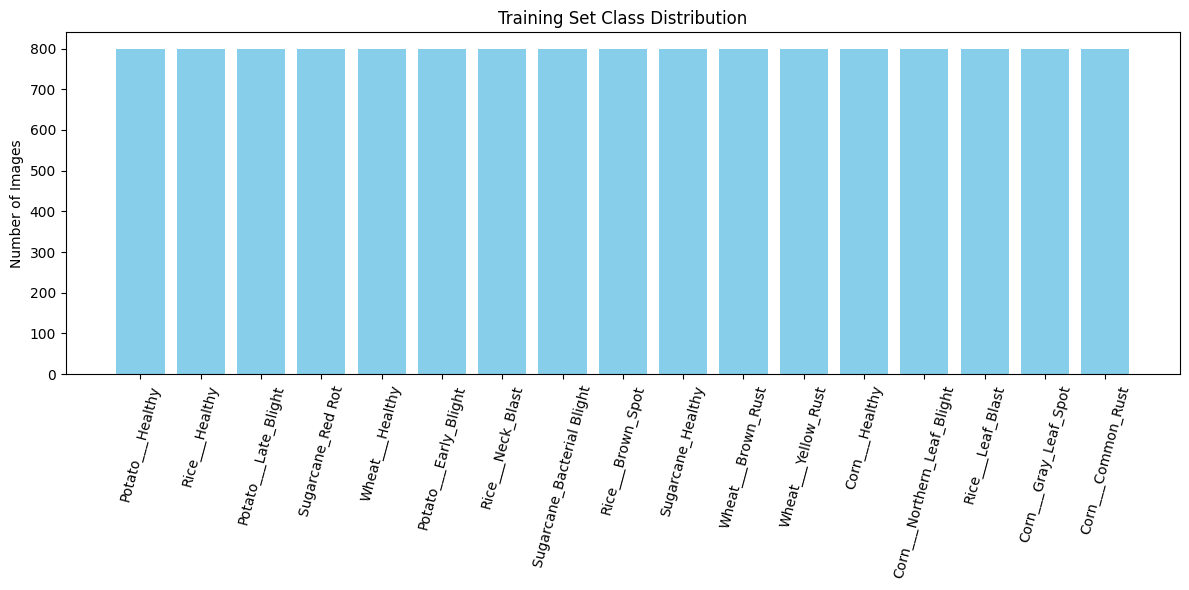

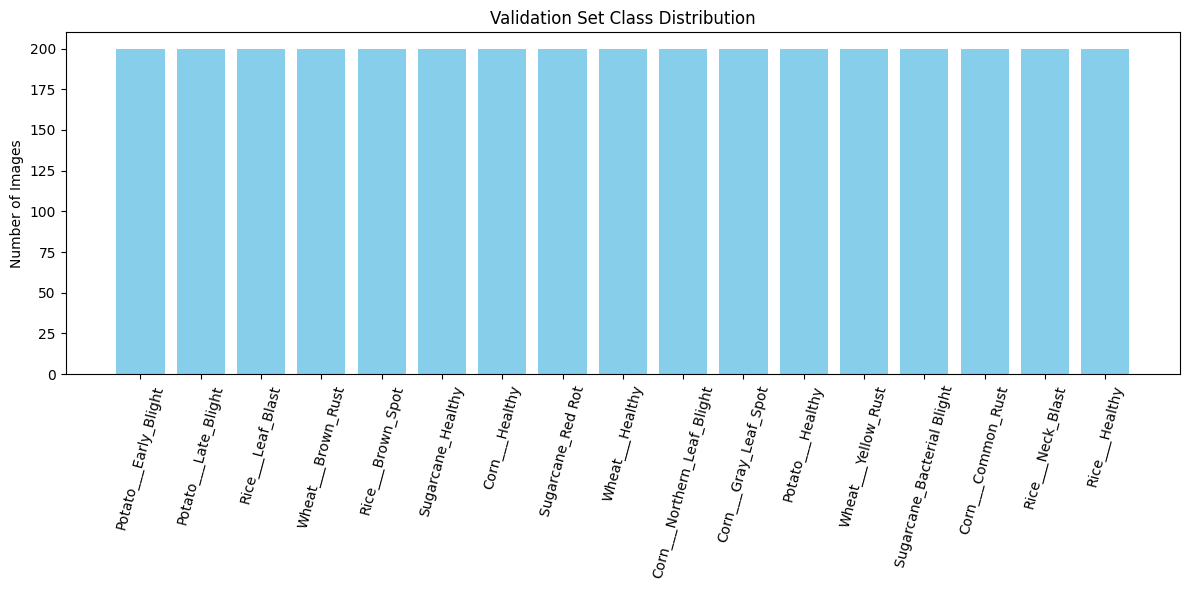

In [48]:
from collections import Counter
import matplotlib.pyplot as plt


class_names = os.listdir('/kaggle/input/top-agriculture-crop-disease/Crop Diseases')  # uses ImageFolder class_to_idx

def plot_class_distribution(labels, title):
    counter = Counter(labels)
    # Convert to class names
    name_counts = {class_names[k]: v for k, v in counter.items()}
    
    # Bar plot
    plt.figure(figsize=(12, 6))
    plt.bar(name_counts.keys(), name_counts.values(), color='skyblue')
    plt.xticks(rotation=75)
    plt.title(title)
    plt.ylabel("Number of Images")
    plt.tight_layout()
    plt.show()

# Get label list from both datasets
train_labels = train_ds.labels
val_labels   = val_ds.labels

# Plot distributions
plot_class_distribution(train_labels, "Training Set Class Distribution")
plot_class_distribution(val_labels, "Validation Set Class Distribution")


In [49]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tqdm import tqdm
import numpy as np


In [56]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from torchvision.models import inception_v3, Inception_V3_Weights

weights = Inception_V3_Weights
model = inception_v3(weights=weights,aux_logits=True)
model.fc = nn.Linear(model.fc.in_features, 17)
model = model.to(device)

In [57]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [61]:
def train_model(model, train_loader, val_loader, num_epochs=10):
    os.makedirs('./kaggle/working', exist_ok=True)  # Create the directory if it doesn't exist
    for epoch in range(num_epochs):
        model.train()
        train_preds, train_labels = [], []
        running_loss = 0.0

        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs,_ = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            train_preds.extend(outputs.argmax(1).cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

        train_acc = accuracy_score(train_labels, train_preds)
        torch.save(model.state_dict(), f'./kaggle/working/inception_model_epoch{epoch}.pth')

        # Validation
        model.eval()
        val_preds, val_labels = [], []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)

                val_preds.extend(outputs.argmax(1).cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        val_acc = accuracy_score(val_labels, val_preds)

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {running_loss/len(train_loader):.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Acc: {val_acc:.4f}")
        print(classification_report(val_labels, val_preds, target_names=class_names))
        print("Confusion Matrix:")
        print(confusion_matrix(val_labels, val_preds))


In [62]:
import torchvision.transforms.functional as TF
import torch.nn.functional as F
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
import numpy as np

def evaluate_image_quality(model, loader):
    model.eval()
    sample_images, sample_labels = next(iter(loader))
    img = sample_images[0].unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(img)
    
    img_np = TF.to_pil_image(sample_images[0]).convert('RGB')
    output_np = img_np  # use GT or compare with reconstruction (if applicable)

    img_arr = np.array(img_np)
    pred_arr = np.array(output_np)

    print("PSNR:", psnr(img_arr, pred_arr))
    print("SSIM:", ssim(img_arr, pred_arr, multichannel=True))
    print("MSE:", np.mean((img_arr - pred_arr) ** 2))


In [63]:
train_model(model, train_loader, val_loader, num_epochs=8)

100%|██████████| 425/425 [1:47:50<00:00, 15.23s/it]  
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/8
Train Loss: 0.0885, Train Acc: 0.9724
Val Acc: 0.8062
                             precision    recall  f1-score   support

Corn___Northern_Leaf_Blight       0.99      0.99      0.99       200
        Wheat___Yellow_Rust       0.00      0.00      0.00       200
 Sugarcane_Bacterial Blight       1.00      1.00      1.00       200
           Potato___Healthy       0.50      1.00      0.67       200
          Rice___Neck_Blast       0.97      1.00      0.99       200
             Corn___Healthy       1.00      0.01      0.02       200
         Wheat___Brown_Rust       0.49      0.97      0.66       200
      Corn___Gray_Leaf_Spot       0.00      0.00      0.00       200
          Rice___Brown_Spot       0.75      0.97      0.85       200
          Sugarcane_Red Rot       0.50      0.85      0.63       200
          Sugarcane_Healthy       1.00      1.00      1.00       200
            Wheat___Healthy       0.98      0.95      0.97       200
          Rice___Leaf_Blast       1.00

100%|██████████| 425/425 [1:49:20<00:00, 15.44s/it]  
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 2/8
Train Loss: 0.0674, Train Acc: 0.9791
Val Acc: 0.8059
                             precision    recall  f1-score   support

Corn___Northern_Leaf_Blight       0.99      0.99      0.99       200
        Wheat___Yellow_Rust       0.00      0.00      0.00       200
 Sugarcane_Bacterial Blight       1.00      1.00      1.00       200
           Potato___Healthy       0.50      1.00      0.67       200
          Rice___Neck_Blast       1.00      1.00      1.00       200
             Corn___Healthy       0.00      0.00      0.00       200
         Wheat___Brown_Rust       0.50      1.00      0.66       200
      Corn___Gray_Leaf_Spot       0.00      0.00      0.00       200
          Rice___Brown_Spot       0.70      0.97      0.81       200
          Sugarcane_Red Rot       0.52      0.84      0.65       200
          Sugarcane_Healthy       1.00      1.00      1.00       200
            Wheat___Healthy       1.00      0.92      0.96       200
          Rice___Leaf_Blast       1.00

100%|██████████| 425/425 [1:48:59<00:00, 15.39s/it]  
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 3/8
Train Loss: 0.0601, Train Acc: 0.9803
Val Acc: 0.8029
                             precision    recall  f1-score   support

Corn___Northern_Leaf_Blight       0.99      0.99      0.99       200
        Wheat___Yellow_Rust       1.00      0.01      0.03       200
 Sugarcane_Bacterial Blight       1.00      1.00      1.00       200
           Potato___Healthy       0.51      1.00      0.68       200
          Rice___Neck_Blast       0.97      1.00      0.98       200
             Corn___Healthy       0.00      0.00      0.00       200
         Wheat___Brown_Rust       0.50      0.99      0.66       200
      Corn___Gray_Leaf_Spot       0.00      0.00      0.00       200
          Rice___Brown_Spot       0.74      0.95      0.83       200
          Sugarcane_Red Rot       0.51      0.89      0.65       200
          Sugarcane_Healthy       1.00      1.00      1.00       200
            Wheat___Healthy       1.00      0.98      0.99       200
          Rice___Leaf_Blast       1.00

  5%|▍         | 21/425 [05:22<1:43:30, 15.37s/it]


KeyboardInterrupt: 

In [66]:
state_dict = torch.load('/kaggle/working/kaggle/working/inception_model_epoch2.pth')

model.load_state_dict(state_dict)


<All keys matched successfully>

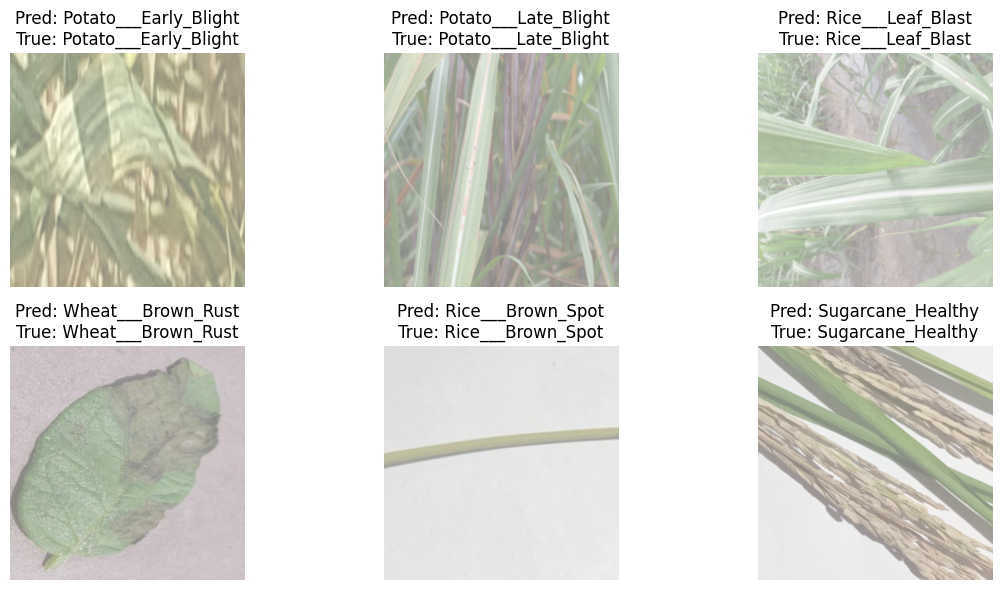

In [69]:
# Put model in eval mode and get one batch
model.eval()
dataiter = iter(val_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

# Run inference
with torch.no_grad():
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

# Show predictions with class names
import matplotlib.pyplot as plt
import numpy as np

def imshow(img, title=None):
    img = img / 2 + 0.5  # unnormalize if needed
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title:
        plt.title(title)
    plt.axis('off')

# Display 6 images with predicted and true class names
plt.figure(figsize=(12, 6))
for idx in range(6):
    plt.subplot(2, 3, idx + 1)
    imshow(images[idx], title=f'Pred: {class_names[preds[idx]]}\nTrue: {class_names[labels[idx]]}')
plt.tight_layout()
plt.show()
